<a href="https://colab.research.google.com/github/kiakass/python/blob/master/Ch06_4_%EB%B0%B0%EA%B9%85_%EB%B6%80%EC%8A%A4%ED%8C%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch06_4.DT_Bagging_Adaboosting

## 1.기본 package 설정

In [1]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환
from sklearn import datasets # python 저장 데이터 가져오기

## 3.데이터 전처리
from sklearn.preprocessing import StandardScaler # 연속변수의 표준화
from sklearn.preprocessing import LabelEncoder # 범주형 변수 수치화

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split 

## 5.분류모델구축 (3장.p.83~130)
from sklearn.tree import DecisionTreeClassifier # 결정 트리
# from sklearn.naive_bayes import GaussianNB # 나이브 베이즈
#from sklearn.neighbors import KNeighborsClassifier # K-최근접 이웃
# from sklearn.linear_model import Perceptron # 퍼셉트론
#from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모델
# from sklearn.svm import SVC # 서포트 벡터 머신(SVM)
# from sklearn.neural_network import MLPClassifier # 다층인공신경망

## 5_1.앙상블 모델 구축 (7장.p.252~288)
#from sklearn.ensemble import VotingClassifier # 과반수 투표(Majority Voting) 
from sklearn.ensemble import BaggingClassifier # 배깅(Bagging) 
from sklearn.ensemble import AdaBoostClassifier # 부스팅(Boosting) 
#from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트


## 6.모델검정
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

## 7.최적화
from sklearn.model_selection import cross_validate # 교차타당도
from sklearn.pipeline import make_pipeline # 파이프라인 구축
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_score # 교차타당도 # 추가

## 2.데이터 가져오기

### 2.1 데이터프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [2]:
#from google.colab import drive
#
#drive.mount('/content/gdrive')
#bank_df = pd.read_csv('./gdrive/My Drive/data/bank.csv')

In [3]:
# 1. 데이터 로딩

bank_df = pd.read_csv('https://raw.githubusercontent.com/kiakass/share/master/bank.csv')

## data , target 으로 분리
X = bank_df.drop(['Y'], axis=1)
y = bank_df['Y']

# 2. data 전처리
# 범주형 변수인 Education 을 문자로 바꾼후 onehot encoding 하는 방법입니다.
X['Education'] = X['Education'].replace ([1,2,3], ['Under','Grad','Prof'])
X = pd.get_dummies(X[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Securities.Account', 'CD.Account', 'Online', 'CreditCard']],
                   columns=['Education'],
                   drop_first = True)
X.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities.Account,CD.Account,Online,CreditCard,Education_Prof,Education_Under
0,25,1,49,4,1.6,0,1,0,0,0,0,1
1,45,19,34,3,1.5,0,1,0,0,0,0,1
2,39,15,11,1,1.0,0,0,0,0,0,0,1
3,35,9,100,1,2.7,0,0,0,0,0,0,0
4,35,8,45,4,1.0,0,0,0,0,1,0,0


## 3.데이터 전처리

### 3.1 data(X) 레이블 인코딩
- 문자형 자료를 숫자(범주형)로 인코딩 -> 범주형 변수를 가변수로 처리 : One Hot Encording
- 숫자형 자료를 표준화
- 단, 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 : 원본데이터 그대로 유지

- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

### 3.2 Class(target) 레이블 인코딩
- class(y)가 숫자형으로 되어 있기 때문에 변환 없음

In [4]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: Y, Length: 5000, dtype: int64

## 4.훈련/검증용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할

In [5]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, 
                         test_size=0.3, 
                         random_state=1, 
                         stratify=y)

## 5.모델구축
- 기본 및 배깅 모델 구축

In [6]:
tree = DecisionTreeClassifier(max_depth=5, # 수정
                              criterion='entropy',
                              random_state=1)

bagging = BaggingClassifier(base_estimator=tree, # 수정
                            n_estimators=500,     # Sample 을 몇개나 -> Decision Tree 갯수 
                            max_samples=1.0, 
                            max_features=1.0, 
                            bootstrap=True, 
                            bootstrap_features=False, 
                            n_jobs=1, 
                            random_state=1)

adaboost = AdaBoostClassifier(base_estimator=tree, # 수정
                              n_estimators=500,
                              learning_rate = 0.1, # 수정
                              random_state=1)

clf_labels = ['Decision tree', 'Bagging', 'Ada boost']

all_clf = [tree, bagging, adaboost]

## 6. 모델검정

### 6.1 AUC 검정

In [7]:
import time

for clf, label in zip(all_clf, clf_labels):
    start = time.time()  # 시작 시간 저장
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("[%s] , ROC AUC: %0.3f (+/- %0.3f), time : %.3f sec"
          % (label, scores.mean(), scores.std(), time.time() - start ))

[Decision tree] , ROC AUC: 0.983 (+/- 0.018), time : 0.092 sec
[Bagging] , ROC AUC: 0.997 (+/- 0.002), time : 19.009 sec
[Ada boost] , ROC AUC: 0.991 (+/- 0.011), time : 40.143 sec


### 6.2 ROC 곡선 그리기


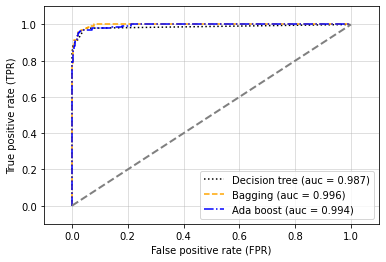

In [8]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 6.3 정오분류표로 검정

In [9]:
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [10]:
y_pred = adaboost.predict(X_test)

In [11]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],1350,6
True[1],24,120


In [12]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 30
정확도: 0.980
정밀도: 0.952
재현율: 0.833
F1: 0.889


In [13]:
tree = DecisionTreeClassifier(max_depth=2, # 수정
                              criterion='entropy',
                              random_state=1)

bagging = BaggingClassifier(base_estimator=tree, # 수정
                            n_estimators=500,     # Sample 을 몇개나 -> Decision Tree 갯수 
                            max_samples=1.0, 
                            max_features=1.0, 
                            bootstrap=True, 
                            bootstrap_features=False, 
                            n_jobs=1, 
                            random_state=1)

adaboost = AdaBoostClassifier(base_estimator=tree, # 수정
                              n_estimators=500,
                              learning_rate = 0.1, # 수정
                              random_state=1)

clf_labels = ['Decision tree', 'Bagging', 'Ada boost']

all_clf = [tree, bagging, adaboost]

In [14]:
def test_validate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
    #print("confusion_matrix : \n", model)
    print(confmat)
    #print("model : \n", model)
    print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
    print('정확도: %.3f' % accuracy_score(y_test, y_pred))
    print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
    print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
    print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

In [15]:
clf_labels = ['Decision tree', 'Bagging', 'Ada boost']
all_clf = [tree, bagging, adaboost]

for clf, label in zip(all_clf, clf_labels):
    start = time.time()  # 시작 시간 저장
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("[%s] , ROC AUC: %0.3f (+/- %0.3f), time : %.3f sec"
          % (label, scores.mean(), scores.std(), time.time() - start ))
    test_validate(clf)

[Decision tree] , ROC AUC: 0.965 (+/- 0.011), time : 0.077 sec
         Predict[0]  Predict[1]
True[0]        1312          44
True[1]          43         101
잘못 분류된 샘플 개수: 87
정확도: 0.942
정밀도: 0.697
재현율: 0.701
F1: 0.699
[Bagging] , ROC AUC: 0.969 (+/- 0.011), time : 15.751 sec
         Predict[0]  Predict[1]
True[0]        1312          44
True[1]          43         101
잘못 분류된 샘플 개수: 87
정확도: 0.942
정밀도: 0.697
재현율: 0.701
F1: 0.699
[Ada boost] , ROC AUC: 0.995 (+/- 0.005), time : 23.085 sec
         Predict[0]  Predict[1]
True[0]        1347           9
True[1]          23         121
잘못 분류된 샘플 개수: 32
정확도: 0.979
정밀도: 0.931
재현율: 0.840
F1: 0.883
